In [1]:
import math
import itertools
from collections.abc import Iterable, Collection, Container, Mapping
from numbers import Number
from typing import Tuple, List, Union, Optional

import yaml

import numpy as np

import cv2 as cv

%matplotlib widget
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
class RRT(object):
    def __init__(self, mapImgG: np.ndarray):
        #Map in binary 'color space'
        self.reset()
        self.setMap(mapImgG)
    
    def reset(self):
        self.nodes = []
        self.idTable = dict()
        self.nodeChild = dict()
        self.nodeParent = dict()
        self.nodeCost = []
        self.path = []
        self.reach = []
        self.samples = []
        self.maskCalcs = dict()
        
        self.map = None
        self.mShape = None
        
        self.start = None
        self.end = None
        
        self.found = False
    
    def setMap(self, mapImgG: np.ndarray):
        self.map = mapImgG
        self.mShape = np.array(self.map.shape)
        
    def setGoals(self, startPoint: tuple, endPoint: tuple):
        self.start = startPoint
        self.end = endPoint
        
        self.nodes.append(self.start)
        self.nodeCost.append(0.0)
        self.nodeChild[self.start] = []
        self.nodeParent[self.start] = None
        self.idTable[self.start] = 0
        
    def roundClipToEdge(self, vertices):
        #vertices is (Nx2) array
        return np.clip(np.round(vertices).astype(np.int32), [0,0], self.mShape[::-1]-1)
    
    def steer(self, v1, v2, dQ):
        #Straight line steer from v1 to v2 
        #Give vertex
        
        moveDir = v2-v1
        moveAng = np.arctan2(moveDir[1], moveDir[0])
        pathV = np.vstack([np.arange(0, math.ceil(dQ), 1, dtype=np.float32), np.zeros(dQ)])
        pathT = np.matmul(rotation2D(moveAng), pathV)
        
        #print((pathT.T+v1).shape)
        
        pathPixels = self.roundClipToEdge(pathT.T + v1)
        
        #Filter for only unique pixels
        pathPixelsEncode = pathPixels[:,0]*self.mShape[1] + pathPixels[:,1]
        uniquePixels, uniqueIndex = np.unique(pathPixelsEncode, return_index=True)
        uniqueIndex.sort()
        
        #Unique Index contains filtered(no duplicate) sorted list of pixels from v1 to v2
        pathPixelsF = pathPixels[uniqueIndex]
        pathPixelsFChange = np.concatenate([pathPixelsF[1:]-pathPixelsF[:-1], np.zeros((1,2), dtype=np.int32)])
        
        #Check connecting cardinal pixels of Diagonal moves]
        checkFreeCardinal = np.logical_or(self.map[pathPixelsF[:,1]+pathPixelsFChange[:,1],pathPixelsF[:,0]] == 0,self.map[pathPixelsF[:,1],pathPixelsF[:,0]+pathPixelsFChange[:,0]] == 0)
        #and check if the pixel itself is free
        checkFreeBlocks = np.logical_and(self.map[pathPixelsF[:,1], pathPixelsF[:,0]] == 0, checkFreeCardinal)
        
        if(np.all(checkFreeBlocks)):
            return pathPixelsF, True
        
        #Find index of first free pixel next to v1
        #If none is free then v1 is blocked in the movement direction -> Dont add vertex cuz it will dup with v1
        hitInd = -1 if np.all(np.logical_not(checkFreeBlocks)) else np.argmin(checkFreeBlocks)
        
        #Return list of pixel up to the blocked pixel and whether it covers the dQ
        if(hitInd != -1):
            return pathPixelsF[:hitInd], False
        else:
            return pathPixelsF[:0], False
    
    def obstacleFree(self, v1, v2):
        #Check if v2 can be reached by v1 with straight line
        pathPixels, _ = self.steer(v1,v2, math.ceil(math.sqrt(np.sum(np.square(self.mShape)))))
        try:
            if(np.any(np.all(pathPixels == v2, axis=1))):
                return True
        except:
            pass
        return False
        
    def recalculateCost(self, p, v):
        #Recalculate cost of tree <parent + nested child>
        ind = self.idTable[v]
        #self.nodeCost[ind] = (v[0]-p[0])**2+(v[1]-p[1])**2 + self.nodeCost[self.idTable[p]] #Cost calculated with distance squared
        self.nodeCost[ind] = math.sqrt((v[0]-p[0])**2+(v[1]-p[1])**2) + self.nodeCost[self.idTable[p]]
        for c in self.nodeChild[v]:
            self.recalculateCost(v, c)
        
    
    def addNode(self, dQ, greedyBias=0.05, strict=False, neighbourRad = 0):
        #dQ > 0
        #Random Config
        while True:
            
            if(random.random() < (1-greedyBias)):
                rConf = self.roundClipToEdge(np.multiply(self.mShape[::-1], np.random.uniform(size=(2))))
            else:
                rConf = np.array(self.end)
            
            if(self.map[rConf[1], rConf[0]] == 0):
                break
        
        self.samples.append(tuple(rConf))
        
        #Nearest Node
        nodeVec = np.array(self.nodes, dtype=np.float32)
        nodeDiff = nodeVec-rConf
        nodeDists = np.sum(np.multiply(nodeDiff, nodeDiff), axis=1)
        nodeDistsIndexSort = np.argsort(nodeDists)
        nodeDistsSort = nodeDists[nodeDistsIndexSort]
        
        extendInd = nodeDistsIndexSort[0]
        
        nearestNode = self.nodes[extendInd]
        nearestNodeNp = nodeVec[extendInd]
        
        path, maxDistMoved = self.steer(nearestNodeNp, rConf, dQ)
        
        if(len(path) == 0):
            #Blocked
            return self.found
        
        if(strict and not maxDistMoved):
            #Strictly max step no collision
            return self.found
        
        newConf = rConf if np.any(np.all(path == np.array(rConf), axis=1)) else path[-1]
        newConf = np.array(self.end) if np.any(np.all(path == np.array(self.end), axis=1)) else newConf #Forced end point if pass end point for optimization
        newConfT = tuple(newConf)

        #newConfCost = nodeDistsSort[0] + self.nodeCost[extendInd] #Cost calculated with distance squared
        newConfCost = np.sqrt(nodeDistsSort[0]) + self.nodeCost[extendInd]
        
        #Find least cost neighbour
        newConfV = nodeVec - newConf
        newConfDists = np.sum(np.multiply(newConfV, newConfV), axis=1) 
        
        
        neighbourMask = newConfDists <= neighbourRad*neighbourRad
        nodeCosts = np.array(self.nodeCost)
        #nodeAddCosts = nodeCosts + np.sqrt(newConfDists) #Cost calculate with distance squared
        nodeAddCosts = nodeCosts + np.sqrt(newConfDists)
        
        nodeAddCostsN = nodeAddCosts[neighbourMask]
        nodeAddCostsNIndexSort = np.argsort(nodeAddCostsN)
        
        indexFull = np.arange(len(self.nodes), dtype=np.int32)
        
        indexLink = indexFull[neighbourMask][nodeAddCostsNIndexSort]
        nodeAddCostsNSort = nodeAddCostsN[nodeAddCostsNIndexSort]
        costsMask = nodeAddCostsNSort < newConfCost
        
        passCosts = nodeAddCostsNSort[costsMask]
        passCostsIndex = indexLink[costsMask]
        
        minInd = extendInd
        minCost = newConfCost
        
        for i in range(len(passCostsIndex)):
            if(self.obstacleFree(nodeVec[passCostsIndex[i]], newConf)):
                minInd = passCostsIndex[i]
                minCost = passCosts[i]
                break
                
        minNode = self.nodes[minInd]

        #Flag to see if new node is inserted or not
        inserted = 0
        newPath = False
        
        addNode = False
        rewire1 = False
        rewire2 = False
        
        #Create connection to new node
        if(newConfT not in self.nodes):
            addNode = True
            if(np.all(newConf - rConf < 0.5)):
                self.reach.append(newConfT)
            
            self.idTable[newConfT] = len(self.nodes)
            self.nodes.append(newConfT)
            
            self.nodeChild[newConfT] = []
            self.nodeParent[newConfT] = minNode

            self.nodeChild[minNode].append(newConfT)
            self.nodeCost.append(minCost)
            inserted = -1
            
            if(newConfT == self.end):
                self.found = True
                newPath = True
            
        else:
            
            newConfTIndex = self.idTable[newConfT]
            
            if(self.nodeCost[newConfTIndex] > minCost):
                #Rewire to less cost parent
                rewire1 = True
                p = self.nodeParent[newConfT]
                self.nodeChild[p].remove(newConfT)

                self.nodeParent[newConfT] = minNode
                self.nodeChild[minNode].append(newConfT)

                self.recalculateCost(minNode, newConfT)

                
        #Rewire remaining neighbour nodes
        #costFromNew = minCost + newConfDists # Cost calculate with distance squared
        costFromNew = minCost + np.sqrt(newConfDists)
        newNeighbourMask = neighbourMask[:]
        newNeighbourMask[minInd] = False
        
        rewireMask = costFromNew[newNeighbourMask] < nodeCosts[newNeighbourMask]
        rewireIndex = indexFull[newNeighbourMask][rewireMask]
        
        for i in range(len(rewireIndex)):
            testNode = nodeVec[rewireIndex[i]]
            testNodeT = tuple(testNode)
            if(self.obstacleFree(testNode, newConf) and testNodeT != newConfT):
                #Rewire
                rewire2 = True
                p = self.nodeParent[testNodeT]
                self.nodeChild[p].remove(testNodeT)
                
                self.nodeParent[testNodeT] = newConfT
                self.nodeChild[newConfT].append(testNodeT)
                
                self.recalculateCost(newConfT, testNodeT)
        
        return self.found
    
    def constructPath(self):
        self.path = []
        if(self.found):
            tempN = self.end
            while(tempN is not None):
                self.path.append(tempN)
                tempN = self.nodeParent[tempN]
    
    
    def showState(self, pointerRad = 5, lineWidth = 2, path=True, reach=True, sample=True):
        #Return map marked
        img = 255*np.stack([self.map, self.map, self.map], axis=-1)
        
        #Edges
        for k,v in self.nodeParent.items():
            if(v is None):
                continue
            img = cv.line(img, k, v, (0,255,255), lineWidth)
            
        #Nodes
        nodes = self.nodes[:]
        if(self.end not in self.nodes):
            nodes.append(self.end)

        for n in nodes:
            c = (0, 255, 255)
            img = cv.circle(img, n, pointerRad, c, thickness=-1)
            
        if(len(self.path) > 0 and path):
            for i in range(len(self.path)-1):
                img = cv.line(img, self.path[i], self.path[i+1], (0,0,255), lineWidth)
            for n in self.path:
                img = cv.circle(img, n, pointerRad, (0,0,255), thickness=-1)
        
        if(reach):
            for n in self.reach:
                img = cv.circle(img, n, pointerRad, (255, 0 ,255), thickness=-1)
        
        if(len(self.samples) > 0 and sample):
            img = cv.circle(img, self.samples[-1], pointerRad, (255, 255 ,0), thickness=-1)
            
        img = cv.circle(img, self.start, pointerRad, (0, 255, 0), thickness=-1)
        img = cv.circle(img, self.end, pointerRad, (255, 0, 0), thickness=-1)
            
        return img

In [2]:
def get_point_line_parallel_perpendicular(points: np.ndarray, p: np.ndarray, v_hat: np.ndarray) -> np.ndarray:
    """Get point parallel distance from p and (perpendicular) distance from line defined by position p and direction v_hat
    
    Parameters
    -----------
        points: float np.ndarray[N, 2]
            points to contain in line

        p: float np.ndarray[1, 2]
            position vector of point on line

        v_hat: float np.ndarray[1, 2]
            normalized direction vector of line

    Returns
    -----------
        points_parallel_distance: float np.ndarray[N, ]
            Parallel distance of points to p

        points_perpendicular_distance: float np.ndarray[N, ]
            Perpendicular distance of points to line
    
    """

    line_to_points = points - p
    
    points_parallel_distance = np.sum(np.multiply(line_to_points, v_hat), axis=-1)

    line_to_point_project_normal = line_to_points - np.multiply(np.expand_dims(points_parallel_distance, -1), v_hat)

    points_perpendicular_distance = np.linalg.norm(line_to_point_project_normal, axis=-1)

    return points_parallel_distance, points_perpendicular_distance

In [3]:
PositionType = Tuple[Number, Number]
PointType = np.ndarray
IndexArrayType = np.ndarray

In [84]:
import matplotlib.collections


class RRTStar:
    """RRT* for 2D path planning using straight movements"""

    def __init__(self, map: np.ndarray, map_x_bounds: np.ndarray, map_y_bounds: np.ndarray):
        
        self.map = map # Bool, freespace = False

        self.map_x_bounds = map_x_bounds
        self.map_y_bounds = map_y_bounds

        if len(self.map_x_bounds) - 1 != self.map.shape[1]:
            raise ValueError(f'Received x bounds of length ({len(self.map_x_bounds)}) but map is {self.map.shape}. Expecting x bounds to be 1 more than axis 1 length')
        
        if len(self.map_y_bounds) - 1 != self.map.shape[0]:
            raise ValueError(f'Received x bounds of length ({len(self.map_y_bounds)}) but map is {self.map.shape}. Expecting x bounds to be 1 more than axis 0 length')

        self.map_x_cell_size = self.map_x_bounds[1] - self.map_x_bounds[0]
        self.map_y_cell_size = self.map_y_bounds[1] - self.map_y_bounds[0]

        self.map_corner_phi = np.arctan2(self.map_y_cell_size, self.map_x_cell_size)

        self.map_x_bounds_expanded = np.expand_dims(self.map_x_bounds, -1)
        self.map_y_bounds_expanded = np.expand_dims(self.map_y_bounds, -1)

        self.map_bounds = np.stack(np.meshgrid(self.map_x_bounds, self.map_y_bounds), -1)
        self.map_centers = self.map_bounds[:-1, :-1] + np.array([[[self.map_x_cell_size/2, self.map_y_cell_size/2]]])

        # Assuming uniform grid in x and y
        self.map_x_range = self.map_x_bounds[-1] - self.map_x_bounds[0]
        self.map_y_range = self.map_y_bounds[-1] - self.map_y_bounds[0]
        self.map_position_range = np.array([[self.map_x_range, self.map_y_range]])

        self.map_x_low = self.map_x_bounds[0]
        self.map_y_low = self.map_y_bounds[0]
        self.map_position_low = np.array([[self.map_x_low, self.map_y_low]])

        self.map_x_count = self.map.shape[1]
        self.map_y_count = self.map.shape[0]
        self.map_cell_count = np.array([[self.map_x_count, self.map_y_count]])

        self.reset()

    def reset(self):

        self.index_table : dict[PositionType, int] = dict()
        self.nodes : List[PositionType] = []

        self.node_child : dict[PositionType, List[PositionType]]= dict()
        self.node_parent : dict[PositionType, List[PositionType]] = dict()

        self.node_cost : List[Number] = []
        
        self.path = []
        self.reach = []
        self.samples = []

        self.start_position = None
        self.goal_position = None

        self.found = False

        # debug
        self._random_position = None
        self._extend_point = None
        self._new_position = None

    def set_goals(self, start_position: PositionType, goal_position: PositionType):
        self.start_position = tuple(*self._round_position_to_nearest_center(start_position))
        self.goal_position = tuple(*self._round_position_to_nearest_center(goal_position))

        self.start_position_np: PointType = np.array(self.start_position).reshape(1,2)
        self.goal_position_np: PointType = np.array(self.goal_position).reshape(1,2)

        print(f'{self.start_position=} {self.start_position_np=}')

        self._add_node(self.start_position, 0.0, None)

    def _add_node(self, position: PointType, node_cost: Number, parent: Union[PositionType, None]):

        self.index_table[position] = len(self.nodes)
        self.nodes.append(position)

        self.node_cost.append(node_cost)

        self.node_child[position] = []
        self.node_parent[position] = parent

        if parent is not None:
            self.node_child[parent].append(position)

    def _clip_position_to_edge(self, points: PointType) -> PointType:
        """Clip the points to edge of map

        Parameters:
        points: float np.array[N, 2]
        """

        return np.clip(
            points, a_min=[self.map_x_bounds[0], self.map_y_bounds[0]], a_max=[self.map_x_bounds[-1], self.map_y_bounds[-1]]
        )
    
    def _round_position_to_nearest_center(self, points: PointType) -> PointType:
        """Round to nearest center"""
        grid_indices, _ = self._get_grid_index(points)

        grid_indices_clipped = self._clip_index_to_edge(grid_indices)

        return (self.map_centers[grid_indices_clipped[:,1], grid_indices_clipped[:,0]])

    def _clip_index_to_edge(self, indices: IndexArrayType) -> IndexArrayType:
        """Clip the indices to edge of map

        Parameters:
        indices: int np.array[N, 2]
        """

        return np.clip(
            indices, a_min=0, a_max=self.map_cell_count - 1
        )

    # def _get_grid_index(self, points: List[PointType]) -> Tuple[IndexArrayType, np.ndarray]:
    #     """
    #     Parameters
    #     ----------
    #     points: List[float np.ndarray[N, 2]]
    #         List of points to get grid index of
    #     Returns
    #     -------
    #     grid_index_array: float np.ndarray[N, 2]
    #         Grid indices of points.  If points lie outside the grid, then the index will be clipped
    #     in_grid_mask: bool np.ndarray[N, 2]
    #         Boolean mask desginating which points lies inside the map
        
    #     """

    #     # Take in points in local frame
    #     # Returns grid index + valid points
        
    #     x_slot = np.logical_and(self.map_x_bounds_expanded[:-1] < points[:,0], points[:,0] <= self.map_x_bounds_expanded[1:])
    #     y_slot = np.logical_and(self.map_y_bounds_expanded[:-1] < points[:,1], points[:,1] <= self.map_y_bounds_expanded[1:])

    #     x_inside = np.any(x_slot, axis=0)
    #     x_outside = np.logical_not(x_inside)

    #     y_inside = np.any(y_slot, axis=0)
    #     y_outside = np.logical_not(y_inside)

    #     point_in_grid_mask = np.logical_and(x_inside, y_inside)

    #     grid_index = np.zeros_like(points, dtype=int)
    #     x_index, point_index_x = np.where(x_slot)
    #     grid_index[point_index_x, 0] = x_index

    #     points_x_outside = points[x_outside]
    #     grid_index[x_outside, 0] = (len(self.map_x_bounds) - 1) * (points_x_outside[:, 0] > self.map_x_bounds[-1]).astype(float)

    #     y_index, point_index_y = np.where(y_slot)
    #     grid_index[point_index_y, 1] = y_index

    #     points_y_outside = points[y_outside]
    #     grid_index[y_outside, 1] = (len(self.map_y_bounds) - 1) * (points_y_outside[:, 1] > self.map_y_bounds[-1]).astype(float)

    #     return grid_index, point_in_grid_mask

    def _get_grid_index(self, points: List[PointType]) -> Tuple[IndexArrayType, np.ndarray]:
        """ Fast implementation. Assume uniform grid.
        Parameters
        ----------
        points: List[float np.ndarray[N, 2]]
            List of points to get grid index of

        Returns
        -------
        grid_index_array: float np.ndarray[N, 2]
            Grid indices of points.  If points lie outside the grid, then the index will be clipped
        in_grid_mask: bool np.ndarray[N, 2]
            Boolean mask desginating which points lies inside the map
        
        """
        
        grid_indices = np.floor(np.multiply(self.map_cell_count, np.divide(points - self.map_position_low, self.map_position_range))).astype(int)

        in_grid_mask = np.logical_not(np.any(np.logical_or(grid_indices < 0, grid_indices >= self.map_cell_count), axis=-1))

        return grid_indices, in_grid_mask

    def steer(self, p1: PointType, p2: PointType, dQ: Number, stop_goal_distance: Optional[Number] = None, epsilon: Number = 1e-6) -> Tuple[PointType, bool]:
        """
        Straight line steer between p1 and p2. Checks for collision, return the final point of steer. Raise value error if cant steer: p1, p2 is the same or collision too soon

        Parameters
        ----------
        p1: float np.ndarray[1, 2]
            start point of steer
        p2: float np.ndarray[1, 2]
            end point direction of steer
        dQ: Number
            max distancce to steer for
        stop_goal_distance: Number 
            Consider this point is in goal if within this number. Should be less than smallest grid side to make sure not clipping through walls
        
        epsilon: Number
            numerical stability constant. Use to check equalities

        Returns
        -------
        new_configuration : float np.ndarray[1, 2]
            end point of the steer
        reached_goal: bool
            whether the new configuration is within the stop_goal_distance
        """
        
        # print(f'{p1.shape=} {p2.shape=}')

        direction_vector = p2 - p1
        direction_vector_norm = np.linalg.norm(direction_vector)
        if direction_vector_norm < epsilon:
            # Same point
            raise ValueError(f'Distance between p1 and p2 too low: {direction_vector_norm}. Same point')
        direction_vector_unit = direction_vector / np.expand_dims(direction_vector_norm, -1)
        # print(f'{p1=} {p2=} {dQ=} {direction_vector=}')

        new_point_candidate = p1 + dQ * direction_vector_unit
        new_point = self._clip_position_to_edge(new_point_candidate)
        # new_point = self._round_position_to_nearest_center(new_point)
        # print(f'{new_point_candidate=} {new_point=}')

        # might be different after clip?
        p1_to_new_point_direction = new_point - p1
        p1_to_new_point_distance = np.linalg.norm(p1_to_new_point_direction)

        if p1_to_new_point_distance < epsilon:
            # Same point when clipped
            return ValueError(f'Distance between p1 and new configuration too low: {p1_to_new_point_distance}. Same point. p1: {p1} new_point: {new_point}')

        p1_to_new_point_direction_unit = p1_to_new_point_direction / np.expand_dims(p1_to_new_point_distance, -1)

        # print(f'{p1=} {new_point=} {p1_to_new_point_direction_unit=}')

        # Clip to edge

        # Check for collision
        points_check = np.concatenate(
            [p1, new_point], axis=0
        )

        grid_index_range, in_grid = self._get_grid_index(points_check)

        # in grid must be all true
        sorted_range = np.sort(grid_index_range, axis=0)
        sorted_range[1] += 1 # End range is exclusive when querying

        # print(f'{sorted_range=}')

        # Query only grids enclosing the 2 points
        block_centers = self.map_centers[sorted_range[0,1]:sorted_range[1,1], sorted_range[0,0]:sorted_range[1,0]]
        block_values = self.map[sorted_range[0,1]:sorted_range[1,1], sorted_range[0,0]:sorted_range[1,0]]

        if block_centers.size == 0:
            # Shouldnt ever happen?
            raise ValueError(f'Block centers is zero. {sorted_range=}')

        block_centers_flat = block_centers.reshape(-1,2)
        block_values_flat = block_values.reshape(-1)

        line_perpendicular_angle = np.arctan2(
                abs(p1_to_new_point_direction_unit[0,1]), abs(p1_to_new_point_direction_unit[0,0])
            )
        
        if line_perpendicular_angle < self.map_corner_phi:
            # left - right bound
            distance_threshold = self.map_x_cell_size / (2 * np.cos(line_perpendicular_angle))
        else:
            # top - bottom bound
            distance_threshold = self.map_y_cell_size / (2 * np.sin(line_perpendicular_angle))

        distance_threshold *= 1.5

        block_centers_parallel_distance, block_centers_perpendicular_distance = get_point_line_parallel_perpendicular(block_centers_flat, p1, p1_to_new_point_direction_unit)

        line_block_mask = block_centers_perpendicular_distance <= distance_threshold

        self._line_mask_pre_shuffled = line_block_mask

        # line_block_perpendicular_distance = block_centers_perpendicular_distance[line_block_mask]
        line_block_parallel_distance = block_centers_parallel_distance[line_block_mask]
        line_block_centers_flat = block_centers_flat[line_block_mask]
        # print(f'{line_block_centers_flat=}')

        line_block_value_flat = block_values_flat[line_block_mask]
        # print(f'{line_block_value_flat=}')

        line_order_indices = np.argsort(line_block_parallel_distance)
        self._line_order_block_indices = line_order_indices

        line_block_centers_flat_sorted = line_block_centers_flat[line_order_indices]
        # print(f'{line_block_centers_flat_sorted=}')

        line_block_value_flat_sorted = line_block_value_flat[line_order_indices]
        # print(f'{line_block_value_flat_sorted=}')

        block_not_free_indices = np.where(line_block_value_flat_sorted)[0]
        # print(f'{block_not_free_indices=}')

        # line_order_block_indices = np.argsort(line_block_parallel_distance)
        # self._line_order_block_indices = line_order_block_indices

        # block_centers_flat_sorted = block_centers_flat[line_order_block_indices]
        # print(f'{block_centers_flat_sorted=}')

        # line_order_block_parallel_distance = block_centers_parallel_distance[line_order_block_indices]
        # line_order_block_perpendicular_distance = block_centers_perpendicular_distance[line_order_block_indices]
        
        # line_grid_intersect_mask = np.abs(line_order_block_perpendicular_distance) <= distance_threshold
        # print(f'{line_grid_intersect_mask=}')

        # line_block_values = block_values_flat[line_grid_intersect_mask]
        # print(f'{line_block_values=}')

        # block_not_free_indices = np.where(line_block_values)[0]
        # print(f'{block_not_free_indices=}')

        # new_point = new_point
        if len(block_not_free_indices) != 0:
            # Collided
            first_hit_index = block_not_free_indices[0]
            if first_hit_index - 1 < 0:
                # Collided at start
                raise ValueError(f'Collided at start.')
            
            # Clip to poit on line nearest to block center
            # p1_to_new_point_distance = line_order_block_parallel_distance[first_hit_index - 1]
            # new_point = p1 + p1_to_new_point_distance * p1_to_new_point_direction_unit

            # Round to the center
            # new_point = block_centers_flat[first_hit_index - 1].reshape(1,2)
            new_point = line_block_centers_flat_sorted[first_hit_index - 1].reshape(1,2)

        # print(f'Pre Round: {new_point=}')
        new_point = self._round_position_to_nearest_center(new_point)
        # print(f'Post Round: {new_point=}')

        if stop_goal_distance is None:
            return new_point, False

        # Check new point goal distance

        goal_parallel_distance, goal_perpendicular_distance = get_point_line_parallel_perpendicular(self.goal_position_np, p1, p1_to_new_point_direction_unit)

        return new_point, np.all(goal_perpendicular_distance <= stop_goal_distance) and np.all(goal_parallel_distance <= p1_to_new_point_distance) and np.all(goal_parallel_distance >= 0)
    
    def obstacle_free(self, p1: PositionType, p2: PositionType, epsilon=1e-5) -> bool:

        p1_to_p2 = p2 - p1
        p1_to_p2_distance = np.linalg.norm(p1_to_p2)

        if p1_to_p2_distance < epsilon:
            return True

        try:
            end_point, _ = self.steer(p1, p2, p1_to_p2_distance*1.05)
        except ValueError:
            return False
        
        p1_to_end_point = end_point - p1
        p1_to_end_point_distance = np.linalg.norm(p1_to_end_point)

        return p1_to_p2_distance < p1_to_end_point_distance

    def recalculate_cost(self, parent_node: PointType, vertex: PointType):
        """Recalulate cost and propagate cost update to all children of parent"""
        vertex_index = self.index_table[vertex]

        self.node_cost[vertex_index] = math.sqrt((vertex[0]-parent_node[0])**2+(vertex[1]-parent_node[1])**2) + self.node_cost[self.index_table[parent_node]]

        for child in self.node_child[vertex]:
            self.recalculate_cost(vertex, child)

    def reparent_node(self, node: PointType,  new_parent_node: PointType):

        current_parent_node = self.node_parent[node]

        self.node_child[current_parent_node].remove(node)

        self.node_parent[node] = new_parent_node
        self.node_child[new_parent_node].append(node)

        self.recalculate_cost(new_parent_node, node)

    def sample_random_position(self, greedy_bias: Number = 0.05):
        while True:

            if np.random.random() < (1.0-greedy_bias):
                # Return random sample
                sampled_position = self._clip_position_to_edge(
                    np.multiply((self.map.shape[1] - 1, self.map.shape[0] - 1), np.random.uniform(size=(1,2)))
                )
            else:
                # Goal biased (goal)
                sampled_position = self.goal_position_np

            sampled_position = self._round_position_to_nearest_center(sampled_position)

            # Check if blocked
            grid_index, in_grid = self._get_grid_index(sampled_position)
            # print(f'{sampled_position=} {grid_index=} {in_grid=}')

            if not np.all(in_grid):
                # Shouldnt happen
                # print('Not in grid')
                continue

            # print('Grid Index: {}')
            if self.map[grid_index[0,1], grid_index[0,0]] == False:
                break

        return sampled_position
    
    def step(self, dQ, greedy_bias=0.05, neighbour_radius = 0):
        if self.start_position is None:
            raise ValueError(f'Goal and Start havent been set.')

        random_position = self.sample_random_position(greedy_bias=greedy_bias)

        # Find point on tree closest to random position
        nodes_vector = np.array(self.nodes)
        nodes_difference = random_position - nodes_vector
        nodes_distance = np.linalg.norm(nodes_difference, axis=-1)
        nodes_distance_sort_indices = np.argsort(nodes_distance)

        extend_node_index = nodes_distance_sort_indices[0]

        extend_point = self.nodes[extend_node_index]      
        extend_point_np = np.expand_dims(nodes_vector[extend_node_index], 0)

        self._random_position = random_position
        self._extend_point = extend_point_np

        # Steer
        try:
            new_position, pass_goal = self.steer(extend_point_np, random_position, dQ, stop_goal_distance=(self.map_x_cell_size + self.map_y_cell_size) / 4)
        except ValueError:
            # Cant steer
            return self.found

        # See if passed goal
        if pass_goal:
            new_position = self.goal_position_np

        self._new_position = new_position

        # print(f'{new_position.shape=}')

        # Cost
        # new_position_cost = self.node_cost[extend_node_index] + nodes_distance[extend_node_index] WRONG
        nodes_costs_np = np.array(self.node_cost)
        extend_point_to_new_point = new_position - extend_point_np
        extend_point_to_new_point_distance = np.linalg.norm(extend_point_to_new_point)
        new_position_cost = nodes_costs_np[extend_node_index] + extend_point_to_new_point_distance


        # Find minimum cost neighbour to new point
        nodes_to_new_position = new_position - nodes_vector
        nodes_to_new_position_distance = np.linalg.norm(nodes_to_new_position, axis=-1)

        neighbour_mask = nodes_to_new_position_distance <= neighbour_radius

        # print(f'Neighbour Indices: {np.where(neighbour_mask)}')

        neighbour_costs = nodes_costs_np[neighbour_mask]
        new_position_through_neighbour_cost = neighbour_costs + nodes_to_new_position_distance[neighbour_mask]
        neighbour_candidate_mask = new_position_through_neighbour_cost <= new_position_cost

        # print(f'Neighbour Candidate Indices: {np.where(neighbour_candidate_mask)}')

        neighbour_candidates = nodes_vector[neighbour_mask][neighbour_candidate_mask]
        neighbour_candidates_costs = new_position_through_neighbour_cost[neighbour_candidate_mask]
        neighbour_candidates_indices = np.where(neighbour_mask)[0][neighbour_candidate_mask]

        neighbour_costs_sorted_key = np.argsort(neighbour_candidates_costs)

        neighbour_candidates_sorted = neighbour_candidates[neighbour_costs_sorted_key]
        neighbour_candidates_costs_sorted = neighbour_candidates_costs[neighbour_costs_sorted_key]
        neighbour_candidates_indices_sorted = neighbour_candidates_indices[neighbour_costs_sorted_key]

        minimum_index = extend_node_index
        minimum_cost = new_position_cost

        for extend_candidate, extend_candidate_cost, extend_candidate_index in zip(neighbour_candidates_sorted, neighbour_candidates_costs_sorted, neighbour_candidates_indices_sorted):
            # print(f'Checking Neighbour: {extend_candidate=} {extend_candidate_cost=} {extend_candidate_index=}')
            if self.obstacle_free(np.expand_dims(extend_candidate, axis=0), new_position):
                # print(f'Obstacle Free')
                minimum_index = extend_candidate_index
                minimum_cost = extend_candidate_cost
                break

        minimum_cost_neighbour = self.nodes[minimum_index]
        # print(f'{minimum_cost_neighbour=} {minimum_index=} {minimum_cost=}')

        # Update 
        # print(f'{new_position=}')
        new_position_tuple = tuple(*new_position)
        # print(f'{new_position_tuple=}')

        if new_position_tuple not in self.index_table:
            #  Adding node
            # print(f'Adding Node: {new_position_tuple=} {minimum_cost_neighbour=} {minimum_index=} {minimum_cost=}')
            self._add_node(new_position_tuple, node_cost = minimum_cost, parent = minimum_cost_neighbour)
            # print(self.goal_position)
            if new_position_tuple == self.goal_position:
                self.found = True

        else:
            # Rewire to less  cost parent
            new_position_index = self.index_table[new_position_tuple]

            if self.node_cost[new_position_index] > minimum_cost:
                # Rewire to lesser cost parent
                self.node_cost[new_position_index] = minimum_cost
                self.reparent_node(new_position_tuple, minimum_cost_neighbour)

        # Attemp to rewire neighbours through new node
        cost_from_new = minimum_cost + nodes_to_new_position_distance
        new_neighbour_mask = neighbour_mask[:] # copy
        new_neighbour_mask[minimum_index] = False

        rewire_mask = cost_from_new[new_neighbour_mask] < nodes_costs_np[new_neighbour_mask]
        rewire_indices = np.where(new_neighbour_mask)[0][rewire_mask]

        for rewire_index in rewire_indices:
            attempt_node = nodes_vector[rewire_index]
            attempt_node_tuple = tuple(attempt_node)

            if attempt_node_tuple != new_position_tuple and self.obstacle_free(new_position, np.expand_dims(attempt_node, axis=0)):
                # Rewire
                self.reparent_node(attempt_node_tuple, new_position_tuple)

        return self.found
    
    def trace_path(self):
        
        path = []

        current_node = self.goal_position
        while current_node != self.start_position:
            path.append(current_node)

            current_node = self.node_parent[current_node]

        return path[::-1]
    
    def plot(self, ax: matplotlib.axes.Axes, plot_start: bool = True, plot_goal: bool = True, plot_debug: bool = False, plot_path: bool = True):

        # TODO: Change imshow extent
        ax.imshow(self.map, extent=[self.map_centers[0,0,0], self.map_centers[-1,-1,0], self.map_centers[-1,-1,1], self.map_centers[0,0,1]])

        node_array = np.array(self.nodes)

        # xx = []
        # yy = []

        lines = []

        for node, parent in self.node_parent.items():
            if(parent is None):
                continue

            # ax.plot([node[0], parent[0]], [node[1], parent[1]])
            lines.append([node, parent])

        #     xx.append([node[0], parent[0]])
        #     yy.append([node[1], parent[1]])

        # if len(xx) > 0:
        #     xx = np.stack(xx, axis=0)
        #     yy = np.stack(yy, axis=0)
                
        #     ax.plot(np.squeeze(xx), np.squeeze(yy))
        #     print(f'{xx=} {yy=}')

        line_collection = matplotlib.collections.LineCollection(lines)
        ax.add_collection(line_collection)

        if len(node_array) > 0:
            ax.scatter(node_array[:,0], node_array[:,1])

        if plot_start and self.start_position is not None:
            ax.scatter(self.start_position_np[:,0], self.start_position_np[:,1], color=(0, 1, 0, 1), label='Start')

        if plot_goal and self.goal_position is not None:
            ax.scatter(self.goal_position_np[:,0], self.goal_position_np[:,1], color=(1, 0, 0, 1), label='Goal')

        if plot_path:
            if self.found:
                
                path_color = (0.5, 0.0, 0.7, 1.0)

                path = self.trace_path()
                path_nodes = np.array(path)

                path_lines = []
                for i in range(len(path) - 1):
                    path_lines.append((path[i], path[i+1]))
                
                path_line_collection = matplotlib.collections.LineCollection(path_lines, colors=path_color)
                ax.add_collection(path_line_collection)

                ax.scatter(path_nodes[:,0], path_nodes[:,1], color=path_color, label='Path Points')



        if plot_debug:

            if self._random_position is not None:
                ax.scatter(self._random_position[:,0], self._random_position[:,1], color=(0.5, 0.5, 0, 1.0), label=f'Random Sample')
            if self._extend_point is not None:
                ax.scatter(self._extend_point[:,0], self._extend_point[:,1], color=(0.5, 0, 0.7, 1.0), label=f'Extend Point')
            if self._new_position is not None:
                
                ax.scatter(self._new_position[:,0], self._new_position[:,1], color=(0.3, 0.6, 0.0, 1.0), label=f'Step Final Point')




    def get_line_grid_indices(self, p1, p2, inflate_radius, epsilon = 1e-5):
        """
        Assume p1 and p2 is on map
        
        Parameters
        ----------
        
        
        """

        # Form line direction
        direction_vector = p2 - p1

        direction_vector_norm = np.linalg.norm(direction_vector)
        if direction_vector_norm < epsilon:
            # Same point
            raise ValueError(f'Distance between p1 and p2 too low: {direction_vector_norm}. Same point')
        
        direction_vector_unit = direction_vector / np.expand_dims(direction_vector_norm, -1)

        # Query related blocks
        points_check = np.concatenate(
            [p1, p2], axis=0
        )

        grid_index_range, in_grid = self._get_grid_index(points_check)

        # in grid must be all true
        sorted_range = np.sort(grid_index_range, axis=0)
        sorted_range[1] += 1 # End range is exclusive when querying

        # TODO: Check if sorted_range is out of range -> if out of range then p1 or p2 is not in map

        clipped_sorted_range = self._clip_index_to_edge(sorted_range)
        block_size = np.squeeze(np.diff(clipped_sorted_range, axis=0))

        if np.any(block_size == 0):
            # Rectangle lies outside of grid
            raise np.zeros((0,2), dtype=int)
        
        block_centers = self.map_centers[sorted_range[0,1]:sorted_range[1,1], sorted_range[0,0]:sorted_range[1,0]]
        
        block_centers_flat = block_centers.reshape(-1,2)

        line_perpendicular_angle = np.arctan2(
                abs(direction_vector_unit[0,1]), abs(direction_vector_unit[0,0])
            )
        
        if line_perpendicular_angle < self.map_corner_phi:
            # left - right bound
            distance_threshold = self.map_x_cell_size / (2 * np.cos(line_perpendicular_angle))
        else:
            # top - bottom bound
            distance_threshold = self.map_y_cell_size / (2 * np.sin(line_perpendicular_angle))

        distance_threshold *= max(1.0, 2.0 * (inflate_radius - 1) + 1)

        block_centers_parallel_distance, block_centers_perpendicular_distance = get_point_line_parallel_perpendicular(block_centers_flat, p1, direction_vector_unit)

        line_block_mask = block_centers_perpendicular_distance <= distance_threshold

        line_block_parallel_distance = block_centers_parallel_distance[line_block_mask]

        line_order_indices = np.argsort(line_block_parallel_distance)

        # Convert to 2d index
        y_indices, x_indices = np.divmod(np.where(line_block_mask)[0][line_order_indices], block_size[0])

        stacked_indices = np.stack([x_indices, y_indices], axis=-1) + clipped_sorted_range[0,:]

        return stacked_indices

    def create_path_mask_indices(self, path: PointType, inflate_radius: Number) -> IndexArrayType:
        """
        Parameters
        ----------
        inflate_radius: Number
            radius to inflate to ( base line at 1 px )
            
        Return
        ------
        path_array_indices:
        """

        path_length = len(path)

        path_indices = []

        for i in range(path_length - 1):
            p1 = np.expand_dims(path[i], 0)
            p2 = np.expand_dims(path[i + 1], 0)

            path_indices.append(self.get_line_grid_indices(p1, p2, inflate_radius))

        path_indices_np = np.concatenate(path_indices, axis=0)

        return path_indices_np

In [21]:
map_file = 'data/test_map_1.png'

In [22]:
map_raw = cv.imread(map_file)
map_gray = cv.cvtColor(map_raw, cv.COLOR_BGR2GRAY)
map_binary = map_gray != 0

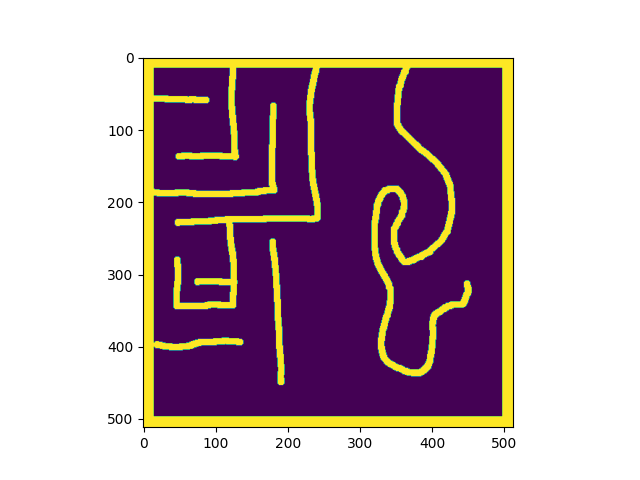

In [23]:
fig1 = plt.figure()
ax1 = fig1.gca()

ax1.imshow(map_binary.astype(np.float32))

In [24]:
map_cell_size = 1.0

map_x_offset = -50.0# -0.5
map_y_offset = 50.0# -0.5

map_x_bounds = np.arange(0, map_binary.shape[1] + 1) * map_cell_size + map_x_offset
map_y_bounds = np.arange(0, map_binary.shape[0] + 1) * map_cell_size + map_y_offset

In [25]:
# start_point = 30.0, 35.5
start_point = 250.0, 350.0
goal_point = 382.5, 332.0

start_point_np = np.array(start_point).reshape(1,2)
goal_point_np = np.array(goal_point).reshape(1,2)

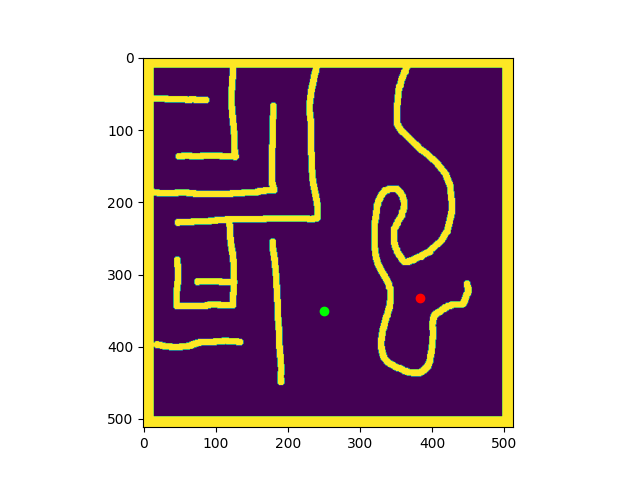

In [26]:
fig2 = plt.figure()
ax2 = fig2.gca()

ax2.imshow(map_binary.astype(np.float32))
ax2.scatter(start_point_np[:,0], start_point_np[:, 1], c=[(0, 1, 0, 1)])
ax2.scatter(goal_point_np[:,0], goal_point_np[:, 1], c=[(1, 0, 0, 1)])

In [85]:
rrt = RRTStar(map_binary, map_x_bounds, map_y_bounds)

/tmp/ipykernel_1066104/2051059702.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


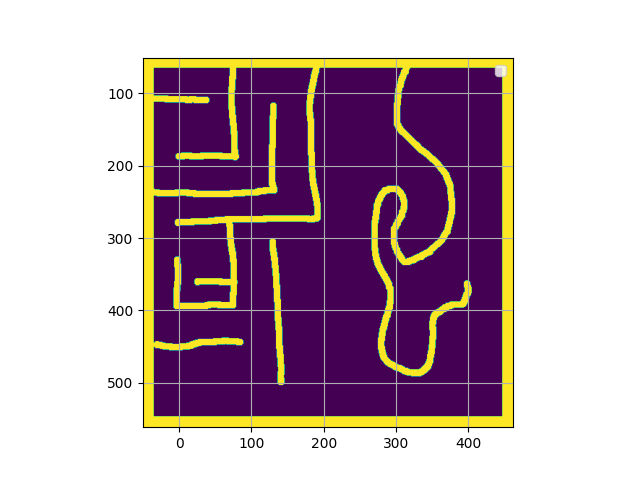

In [86]:
fig3 = plt.figure()
ax3 = fig3.gca()

rrt.plot(ax3, plot_debug=True)
ax3.legend()
ax3.grid()

In [87]:
rrt.set_goals(
    start_point, goal_point
)

self.start_position=(250.5, 350.5) self.start_position_np=array([[250.5, 350.5]])


In [73]:
rrt.step(15.0, neighbour_radius=30.0)

False

In [31]:
rrt._line_order_block_indices[45:55]

array([], dtype=int64)

ValueError: cannot reshape array of size 156 into shape (34,39)

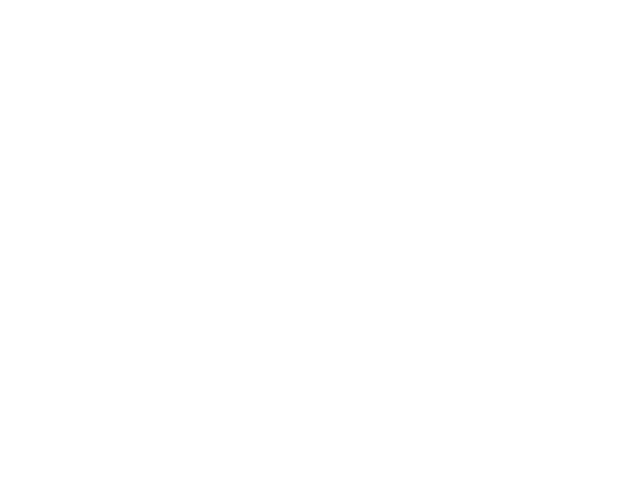

In [32]:
plt.figure()
# plt.imshow(map_binary.astype(np.float32)[49:59, 65:71])

map_patch = rrt.map[39:73, 30:59].astype(np.float32)
line_mask = rrt._line_mask_pre_shuffled.reshape(34,39).astype(np.float32)

# intersection = map_patch * line_mask

print(f'Line Mask Ordered Indices: {rrt._line_order_block_indices[rrt._line_mask_pre_shuffled[rrt._line_order_block_indices]]}')

# plt.imshow(map_patch)
plt.imshow(line_mask)
# plt.imshow(intersection)
# plt.grid()

for (j,i),label in np.ndenumerate(np.arange(line_mask.size).reshape(line_mask.shape)):
    plt.text(i,j,label,ha='center',va='center')
    plt.text(i,j,label,ha='center',va='center')

In [88]:
for i in range(10000):
    if rrt.step(15.0, neighbour_radius=30.0):
        break

In [89]:
i

2036

In [151]:
len(rrt.nodes)

2181

In [368]:
rrt.node_parent

{(30.5, 35.5): None, (49.5, 51.5): (30.5, 35.5)}

In [157]:
rrt.nodes

[(30.0, 35.5)]

In [158]:
rrt.steer(start_point_np, start_point_np + np.array([[1,0]]), 4.5)

[[34 35]]
new_point_candidate=array([[34.5, 35.5]]) new_point=array([[34.5, 35.5]])
sorted_range=array([[30, 35],
       [35, 36]])
line_block_values=array([False, False, False, False, False])


(array([[34.5, 35.5]]), False)

In [159]:
rrt.steer(start_point_np, start_point_np + np.array([[0,1]]), 60.0)

[[30 95]]
new_point_candidate=array([[30. , 95.5]]) new_point=array([[30.5, 95.5]])
sorted_range=array([[30, 35],
       [31, 96]])
line_block_values=array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])


(array([30.5, 52.5]), False)

In [90]:
path = np.array(rrt.trace_path())

In [91]:
path

array([[256.5, 372.5],
       [258.5, 387.5],
       [257.5, 414.5],
       [265.5, 437.5],
       [274.5, 454.5],
       [277.5, 475.5],
       [292.5, 484.5],
       [316.5, 495.5],
       [333.5, 495.5],
       [348.5, 491.5],
       [370.5, 474.5],
       [384.5, 450.5],
       [398.5, 437.5],
       [405.5, 408.5],
       [408.5, 393.5],
       [405.5, 369.5],
       [403.5, 353.5],
       [382.5, 332.5]])

In [99]:
indices_mask = rrt.create_path_mask_indices(
    path, 2.0
)

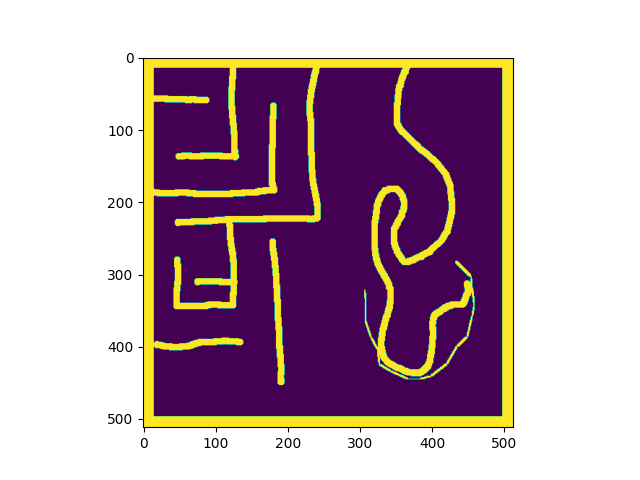

In [100]:
plt.figure()

rrt_map = rrt.map
plt.imshow(rrt_map)

path_image = np.zeros_like(rrt_map)
path_image[indices_mask[:,1], indices_mask[:,0]] = True
plt.imshow(path_image)

plt.imshow(np.logical_or(rrt_map, path_image))

In [98]:
np.any(rrt_map[indices_mask[:,1], indices_mask[:,0]])

False

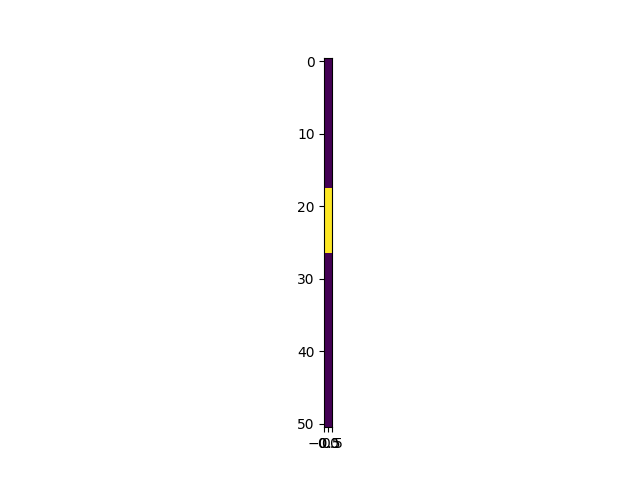

In [145]:
plt.figure()
plt.imshow(map_binary.astype(np.float32)[35:86, 29:30])

In [63]:
np.clip(
    np.array([[35. , 35.5]]), a_min=[map_x_bounds[0], map_y_bounds[0]], a_max=[map_x_bounds[-1], map_y_bounds[-1]]
)

array([[35. , 35.5]])

In [ ]:
def parse_occupancy_grid(message: OccupancyGrid, shift_center: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Parse the grid part of occupancy grid. Assume rotation, only translation offset
    Returns
    -------
    grid: int8 np.ndarray[H, W]
    x_bounds: float np.ndarray[W + 1]
    y_bounds: float np.ndarray[H + 1]
    """
    cell_x_count = message.info.width # cells
    cell_y_count = message.info.height # cells

    cell_resolution = message.info.resolution # m / cell

    grid = np.array(message.data).reshape(cell_y_count, cell_x_count)

    # Assume x and y is aligned with grid
    center_offset = 0.5
    if shift_center:
        center_offset = 0

    x_bounds = (np.arange(0, cell_x_count + 1) - center_offset) * cell_resolution + message.info.origin.position.x
    y_bounds = (np.arange(0, cell_y_count + 1) - center_offset) * cell_resolution + message.info.origin.position.y

    return grid, x_bounds, y_bounds